# Sprint Review: Credal Set Visualization & Input Handling

Goal: Demonstration of the new automatic visualization pipeline.

##### Agenda:
1. Setup: Loading the visualization logic (Backend simulation).
2. Input Handling: How the dispatch_plot function decides what to draw.
3. Live Demo: Testing the pipeline with 2, 3, and 10 classes.

In [1]:
from typing import Any

from matplotlib.patches import Circle, Polygon, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
import matplotlib.pyplot as plt
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import numpy as np
from scipy.spatial import ConvexHull

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


#### 1. Setup & Backend (Simulation)
Note for the review: In this block, we simulate the modules `plot_2d.py` (Interval-Plots), `plot_3d.py` (Ternary-Plots), and `plot_multid.py`(Spider-Plots) that we implemented during this sprint, so this notebook runs standalone.

In [2]:
# --- 1. SPIDER PLOT LOGIC  ---
def radar_factory(num_vars: int, frame: str = "circle") -> np.ndarray:  # noqa: C901
    """Create a radar chart with `num_vars` axes."""
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path: Path) -> Path:
            # Note: _interpolation_steps is internal logic needed for this projection hack
            if path._interpolation_steps > 1:  # noqa: SLF001
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):
        name = "radar"
        PolarTransform = RadarTransform

        def __init__(self, *args: Any, **kwargs: Any) -> None:  # noqa: ANN401
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location("N")

        def fill(self, *args: Any, **kwargs: Any) -> Any:  # noqa: ANN401
            """Override fill to handle closed polygons by default."""
            closed = kwargs.pop("closed", True)
            return super().fill(closed=closed, *args, **kwargs)  # noqa: B026

        def plot(self, *args: Any, **kwargs: Any) -> Any:  # noqa: ANN401
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)
            return lines

        def _close_line(self, line: Any) -> None:  # noqa: ANN401
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels: list[str]) -> None:
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self) -> Any:  # noqa: ANN401
            if frame == "circle":
                return Circle((0.5, 0.5), 0.5)
            if frame == "polygon":
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k")
            msg = f"Unknown value for 'frame': {frame}"
            raise ValueError(msg)

        def _gen_axes_spines(self) -> Any:  # noqa: ANN401
            if frame == "circle":
                return super()._gen_axes_spines()
            if frame == "polygon":
                spine = Spine(axes=self, spine_type="circle", path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(0.5).translate(0.5, 0.5) + self.transAxes)
                return {"polar": spine}
            msg = f"Unknown value for 'frame': {frame}"
            raise ValueError(msg)

    register_projection(RadarAxes)
    return theta


# --- 2. INTERVAL PLOT LOGIC  ---
class IntervalVisualizer:
    def probs_to_coords_2d(self, probs: np.ndarray) -> tuple[float, float]:
        """Convert probabilities to 2D coordinates."""
        _, p2 = probs
        return p2, 0

    def interval_plot(self, probs: np.ndarray, ax: plt.Axes | None = None) -> plt.Axes:
        """Draw an interval plot for binary classification."""
        coords = np.array([self.probs_to_coords_2d(p) for p in probs])

        if ax is None:
            _, ax = plt.subplots(figsize=(6, 1))

        y_marg = np.array([0.1, -0.1])

        # Black base line
        plt.plot([0, 1], [0, 0], color="black", linewidth=2, zorder=0)

        # Purple Area (Credal Set)
        coord_max = np.max(coords[:, 0])
        coord_min = np.min(coords[:, 0])
        ax.fill_betweenx(y_marg, coord_max, coord_min, color="purple", alpha=0.5, zorder=2)
        # Green Points
        ax.scatter(coords[:, 0], coords[:, 1], color="green", zorder=3)

        ax.axis("off")
        ax.set_ylim((-0.2, 0.2))
        y_anchor = -0.07

        # Labels
        y_anchor = -0.07

        ax.text(0, y_anchor - 0.07, "Class A", ha="center", va="top")
        ax.text(1, y_anchor - 0.07, "Class B", ha="center", va="top")

        tick_values = np.linspace(0.0, 1.0, 11)
        tick_length = 0.02
        label_offset = -0.05
        e1 = np.array([0.0, 0.0])
        e2 = np.array([1.0, 0.0])
        edges = [(e1, e2, "A")]

        def lerp(p: np.ndarray, q: np.ndarray, t: float) -> np.ndarray:
            """Linear Interpolation for line values."""
            return (1 - t) * p + t * q

        for p, q, axis_name in edges:  # noqa: B007
            edge_vec = q - p
            normal = np.array([-edge_vec[1], edge_vec[0]])
            normal = normal / np.linalg.norm(normal)

            for t in tick_values:
                pos = lerp(p, q, t)

                tick_start = pos - normal * (tick_length / 2)
                tick_end = pos + normal * (tick_length / 2)
                ax.plot(
                    [tick_start[0], tick_end[0]],
                    [tick_start[1], tick_end[1]],
                    color="black",
                )
                label_pos = pos + normal * label_offset
                ax.text(
                    label_pos[0],
                    label_pos[1],
                    f"{t:.1f}",
                    ha="center",
                    va="center",
                    fontsize=8,
                )
        ax.legend(loc="upper left")

        return ax


# --- 3. TERNARY PLOT LOGIC  ---
class TernaryVisualizer:
    def probs_to_coords(self, probs: np.ndarray) -> tuple[float, float]:
        """Convert 3-class probabilities to Cartesian coordinates for a ternary plot."""
        _, p2, p3 = probs
        x = p2 + 0.5 * p3
        y = (np.sqrt(3) / 2) * p3
        return x, y

    def ternary_plot(self, probs: np.ndarray, ax: plt.Axes | None = None, **scatter_kwargs: Any) -> plt.Axes:  # noqa: ANN401
        """Create a ternary simplex plot."""
        coords = np.array([self.probs_to_coords(p) for p in probs])
        if ax is None:
            _, ax = plt.subplots(figsize=(6, 6))

        def lerp(p: np.ndarray, q: np.ndarray, t: float) -> np.ndarray:
            return (1 - t) * p + t * q

        # Vertices
        v1 = np.array([0.0, 0.0])
        v2 = np.array([1.0, 0.0])
        v3 = np.array([0.5, np.sqrt(3) / 2])

        # Draw Triangle Frame
        ax.plot([v1[0], v2[0], v3[0], v1[0]], [v1[1], v2[1], v3[1], v1[1]], color="black")
        ax.axis("off")

        # Labels for Classes
        offset_x = 0.06
        ax.text(v1[0] + 0.02, v1[1] - offset_x, "Class 1", ha="right", va="top", fontsize=12)
        ax.text(v2[0] + 0.02, v2[1] - offset_x, "Class 2", ha="left", va="top", fontsize=12)
        ax.text(v3[0], v3[1] + offset_x, "Class 3", ha="center", va="bottom", fontsize=12)

        # Ticks and Tick Labels
        tick_values = np.linspace(0.1, 0.9, 11)  # generate 11 ticks between 0.0 and 1.0
        edges = [(v1, v2), (v2, v3), (v3, v1)]
        tick_length = 0.01
        label_offset = -0.05  # Pushes text outwards
        edge_lable = "0.0 / 1.0"
        ax.text(v1[0], v1[1], edge_lable, ha="right", va="top", fontsize=8)
        ax.text(v2[0], v2[1], edge_lable, ha="left", va="top", fontsize=8)
        ax.text(v3[0], v3[1], edge_lable, ha="center", va="bottom", fontsize=8)
        for p, q in edges:
            edge_vec = q - p
            # Normal vector pointing "inside" (rotated 90deg CCW)
            normal = np.array([-edge_vec[1], edge_vec[0]])
            normal = normal / np.linalg.norm(normal)

            for t in tick_values:
                pos = lerp(p, q, t)

                # Draw small tick line
                tick_start = pos - normal * (tick_length / 2)
                tick_end = pos + normal * (tick_length / 2)
                ax.plot([tick_start[0], tick_end[0]], [tick_start[1], tick_end[1]], color="black")

                # Draw tick label (e.g. 0.1, 0.2...)
                label_pos = pos + normal * label_offset
                ax.text(
                    label_pos[0],
                    label_pos[1],
                    f"{t:.1f}",
                    ha="center",
                    va="center",
                    fontsize=8,
                )

        ax.set_aspect("equal", "box")
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, np.sqrt(3) / 2 + 0.2)

        # Scatter points (Blue)
        ax.scatter(coords[:, 0], coords[:, 1], **scatter_kwargs)
        return ax

    def plot_convex_hull(
        self,
        probs: np.ndarray,
        ax: plt.Axes | None = None,
        facecolor: str = "lightgreen",
        alpha: float = 0.4,
        edgecolor: str = "green",
    ) -> plt.Axes:
        """Draw the convex hull (green area) around points."""
        coords = np.array([self.probs_to_coords(p) for p in probs])
        unique = np.unique(coords, axis=0)

        if len(unique) >= 3:
            hull = ConvexHull(coords)
            hull_pts = coords[hull.vertices]
            # Polygon Drawing
            poly = Polygon(hull_pts, closed=True, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, linewidth=2.0)
            ax.add_patch(poly)
        return ax


print("✅ Backend modules loaded successfully.")

✅ Backend modules loaded successfully.


### 2. The Solution: Intelligent Input Handling
The core of this sprint is the `input_handling.py` file. It analyzes the input tensor and decides ("Dispatches") where the data should go.

The Logic:

Shape Check: Do we have `(samples, classes)` or `(models, samples, classes)`? -> Flatten if necessary.

Class Count: Count the last dimension of the array.

Routing:

`n=2` -> Interval Plot

`n=3` -> Triangle Plot

`n>3` -> Spider Plot

In [3]:
def check_shape(input_data: np.ndarray) -> np.ndarray:
    if not isinstance(input_data, np.ndarray):
        msg = "Input must be a numpy array."
        raise TypeError(msg)
    if not np.allclose(input_data.sum(axis=-1), 1, atol=1e-5):
        msg = "Probabilities must sum to 1."
        raise ValueError(msg)
    return input_data


def dispatch_plot(input_data: np.ndarray, labels: list[str] | None = None) -> None:
    """The Main Function."""
    input_data = check_shape(input_data)

    points = input_data.reshape(-1, input_data.shape[-1]) if input_data.ndim == 3 else input_data
    n_classes = points.shape[-1]

    print(f"Detected Input: {n_classes} Classes -> ", end="")

    if n_classes == 2:
        print("Starting Interval Plot...")
        viz = IntervalVisualizer()
        viz.interval_plot(points)
        plt.title("Interval Plot (2 Classes)")
        plt.show()

    elif n_classes == 3:
        print("Starting Triangle Plot...")
        viz = TernaryVisualizer()
        # Plot Scatter
        ax = viz.ternary_plot(points, color="blue", s=50)
        # Plot Green Hull Area
        viz.plot_convex_hull(points, ax=ax, facecolor="lightgreen", alpha=0.4)
        plt.title("Ternary Plot (3 Classes)")
        plt.show()

    elif n_classes >= 4:
        print("Starting Spider Plot...")
        if labels is None:
            labels = [f"C{i + 1}" for i in range(n_classes)]

        # Spider Setup
        theta = radar_factory(n_classes, frame="polygon")
        _, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "radar"})

        ax.set_rgrids([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_ylim(0.0, 1.0)
        ax.set_varlabels(labels)

        # Calculate single MLE point (Mean)
        mean_probs = np.mean(points, axis=0)
        idx_mle = np.argmax(mean_probs)

        # ONLY Plot the Red Dot (No lines, no fills, as per spider.py)
        ax.scatter([theta[idx_mle]], [mean_probs[idx_mle]], s=80, color="red", label="MLE")

        ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
        plt.title("Credal Prediction (Spider)", pad=20)
        plt.show()
    else:
        print("Error: Invalid number of classes.")

### 3. Demo Cases: Does Input Handling Work?
We will now test dispatch_plot with three completely different datasets. We always call the same function, but we expect different plots.

Case A: Binary Classification (2 Classes)

Scenario: Is the email Spam or Ham?

Detected Input: 2 Classes -> Starting Interval Plot...


/var/folders/dg/ff01wrd9633fp_0fp2yzd1cr0000gn/T/ipykernel_68217/219276833.py:135: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper left")


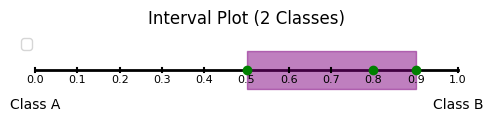

In [4]:
# Data from plot_2d.py
points_2d = np.array(
    [
        [0.2, 0.8],
        [0.5, 0.5],
        [0.1, 0.9],
    ],
)
dispatch_plot(points_2d)

Case B: Ternary Classification (3 Classes)

Scenario: Sentiment Analysis (Negative, Neutral, Positive).

Detected Input: 3 Classes -> Starting Triangle Plot...


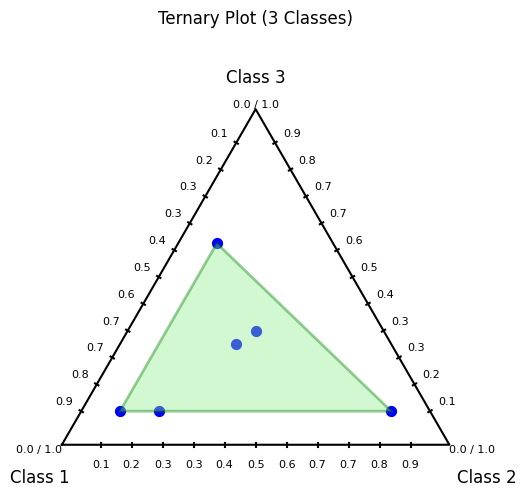

In [5]:
# Data from plot_3d.py
points = np.array(
    [
        [0.7, 0.2, 0.1],
        [0.4, 0.3, 0.3],
        [0.1, 0.8, 0.1],
        [0.8, 0.1, 0.1],
        [0.3, 0.1, 0.6],
        [0.33, 0.33, 0.34],
    ],
)
dispatch_plot(points)

Case C: Multiclass (e.g., CIFAR-10)

Scenario: Image Classification with 10 classes.

Detected Input: 10 Classes -> Starting Spider Plot...


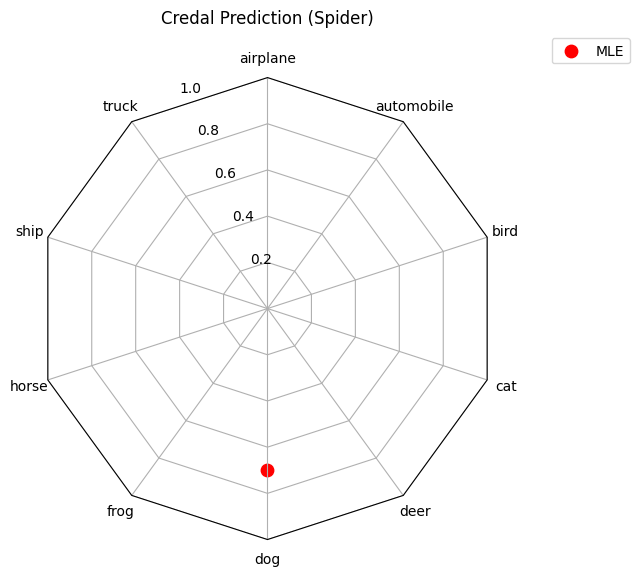

In [6]:
# Data from plot_multd.py
labels = ["airplane", "truck", "ship", "horse", "frog", "dog", "deer", "cat", "bird", "automobile"]

mle = np.array([0.05, 0.03, 0.02, 0.04, 0.05, 0.70, 0.03, 0.02, 0.04, 0.02])

# Wrap as single sample
input_cifar = np.array([mle])

dispatch_plot(input_cifar, labels=labels)

### 4. Tutorial: Using the Input Handler

In this section, we will briefly review how to use the `dispatch_plot` function in practice.

**What does the Input Handler do?**
The Input Handler (`dispatch_plot`) makes the decision for you regarding which visualization is best suited for your data. It automatically performs the following steps:
1. **Validation:** Checks if it is a NumPy array and if the probabilities sum to 1.
2. **Dimension Check:** Determines the number of classes (last dimension of the array).
3. **Routing:** Selects the appropriate plot type (Interval, Ternary, or Spider) and generates the chart.

**New Example: Triangle Plot (3 Classes)**

Scenario: **Net Promoter Score (NPS) Analysis**.
We classify customer feedback, which a model has assigned to three probability categories:
1. **Detractor** (Dissatisfied)
2. **Passive** (Neutral)
3. **Promoter** (Fan)

Since we have **3 classes** here, we expect the Input Handler to automatically select the **Triangle Plot** (Ternary Plot) for us.

--- Tutorial Demo Start ---
Detected Input: 3 Classes -> Starting Triangle Plot...


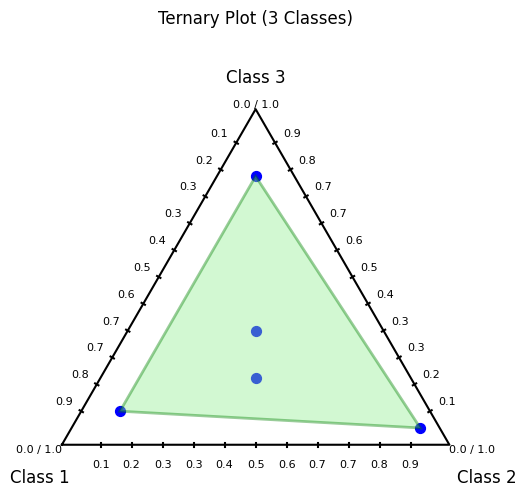

In [7]:
import numpy as np

# 1. Define data
# We simulate 5 customer feedbacks with varying degrees of uncertainty
# Shape: (5 Samples, 3 Classes)
nps_predictions = np.array(
    [
        [0.80, 0.10, 0.10],  # Customer A: Highly likely dissatisfied
        [0.05, 0.90, 0.05],  # Customer B: Highly likely neutral
        [0.10, 0.10, 0.80],  # Customer C: Highly likely fan
        [0.33, 0.33, 0.34],  # Customer D: Model is completely uncertain (Center)
        [0.40, 0.40, 0.20],  # Customer E: Fluctuates between Dissatisfied and Neutral
    ],
)

# 2. Define labels
nps_labels = ["Detractor", "Passive", "Promoter"]

# 3. Automatically generate plot
print("--- Tutorial Demo Start ---")
dispatch_plot(nps_predictions, labels=nps_labels)

**Result Analysis:**
As seen above, `dispatch_plot` recognized that the input has the shape `(N, 3)`.

* The **TernaryVisualizer** was automatically loaded.
* The points were plotted within the simplex triangle.
* The green area (Convex Hull) indicates the uncertainty space (Credal Set) of the predictions.

This means manual selection of the plotting function is no longer necessary.

#### Summary:
We successfully demonstrated:

1. Automation: dispatch_plot correctly detects if 2, 3, or N classes are present.

2. Visualization:

    - 2 Classes -> Bar (Interval).

    - 3 Classes -> Simplex (Triangle) with Convex Hull.

    - 10 Classes -> Radar (Spider) with Uncertainty Area.

3. Tutorial:

    How to successfully use the Input handler, so it plots our data.
